In [1]:
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange
import inference

import cv2
from scipy.ndimage import label
from skimage.measure import regionprops
from skimage.morphology import dilation, disk
from scipy.spatial.distance import cdist

In [2]:
pipe = inference.InferencePipeline()

In [3]:
image_path1 = "image_client/38200/IMG_PNEO3_202308091037033_PMS-FS_ORT_417a75c7-06d7-46c7-c61b-bd9e17f567ab_RGB_R1C1.TIF"
image_path0 = "image_client/38200/IMG_PNEO4_202205111036334_PMS-FS_ORT_999d0cef-9f8e-4176-c158-3cb7cb764895_RGB_R1C1.TIF"

# image_path1 = "image_client/Les_Hermitants/IMG_PHR1A_PMS_202308091107285_ORT_e4f31162-4a88-44b9-c436-10caa0b7bee6_R1C1.TIF"
# image_path0 = "image_client/Les_Hermitants/IMG_PHR1B_PMS_202212051107185_ORT_b3c11138-7d93-449c-c47f-c81267390c0a_R1C1.TIF"

# image_path1 = "image_client/RtedesVergnes/IMG_SPOT6_PMS_202403191025349_ORT_2e19aa66-3cbb-4a0b-cab7-f73d323580e7_R1C1.TIF"
# image_path0 = "image_client/RtedesVergnes/IMG_SPOT7_PMS_202207031033512_ORT_30387a3c-93a9-4a6b-cae6-4ff07285acfa_R1C1.TIF"


In [4]:
seg0, seg1 = pipe.compare(image_path0, image_path1, 0.3)
img0 = pipe.get_image(image_path0)
img1 = pipe.get_image(image_path1)

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

In [5]:
# seg0 = seg0[500:1500, 500:1500]
# seg1 = seg1[500:1500, 500:1500]
# img0 = img0[500:1500, 500:1500]
# img1 = img1[500:1500, 500:1500]

## Utils

In [6]:
def get_instances(mask : np.array):
    # using connected component labeling
    selem = disk(5)
    # dilated_test = dilation(mask, selem)
    # num_labels, labels = cv2.connectedComponents(dilated_test)
    num_labels, labels = cv2.connectedComponents(mask)
    properties = regionprops(labels)

    instances = []
    index = 0
    for prop in properties:

        bbox = prop.bbox
        bbox_height = bbox[2] - bbox[0]
        bbox_width = bbox[3] - bbox[1]
        if bbox_height <= 20 or bbox_width <= 20:
            continue

        # get centroid
        centroid = prop.centroid
        instances.append({
            "label": index,
            "bbox": bbox,
            "centroid": centroid
        })
        index += 1
    return instances


In [7]:
def compute_iou(box1, box2):
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2
    
    xi1 = max(x1_min, x2_min)
    yi1 = max(y1_min, y2_min)
    xi2 = min(x1_max, x2_max)
    yi2 = min(y1_max, y2_max)
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)
    
    union_area = box1_area + box2_area - inter_area
    
    iou = inter_area / union_area if union_area != 0 else 0
    
    return iou

In [8]:
def get_minimum_bounding_box(boxes):
    x_min = min(box[0] for box in boxes)
    y_min = min(box[1] for box in boxes)
    x_max = max(box[2] for box in boxes)
    y_max = max(box[3] for box in boxes)
    return (x_min, y_min, x_max, y_max)

def crop_tensor(tensor, box):
    x_min, y_min, x_max, y_max = box
    # return tensor[y_min:y_max, x_min:x_max]
    return tensor[x_min:x_max, y_min:y_max]

def calculate_iou(tensor1, tensor2):
    assert tensor1.shape == tensor2.shape
    intersection = torch.logical_and(tensor1, tensor2).sum().item()
    union = torch.logical_or(tensor1, tensor2).sum().item()
    iou = intersection / union if union != 0 else 0
    return iou

In [9]:

def get_match(instances_t1,
              instances_t2,):
    # 计算质心距离矩阵
    centroids_t1 = np.array([inst['centroid'] for inst in instances_t1])
    centroids_t2 = np.array([inst['centroid'] for inst in instances_t2])

    distance_matrix = cdist(centroids_t1, centroids_t2)

    # 计算IOU矩阵
    iou_matrix = np.zeros((len(instances_t1), len(instances_t2)))
    for i, inst1 in enumerate(instances_t1):
        for j, inst2 in enumerate(instances_t2):
            iou_matrix[i, j] = compute_iou(inst1['bbox'], inst2['bbox'])

    # 设置匹配阈值，可以根据需要调整
    iou_threshold = 0.5
    distance_threshold = 10.0

    # 找到最佳匹配
    matched_pairs = []
    for i, inst1 in enumerate(instances_t1):
        best_match = None
        best_score = float('inf')
        for j, inst2 in enumerate(instances_t2):
            distance = distance_matrix[i, j]
            iou = iou_matrix[i, j]
            if distance < distance_threshold and iou > iou_threshold:
                score = distance - iou  # 综合考虑距离和IOU
                if score < best_score:
                    best_score = score
                    best_match = j
        if best_match is not None:
            matched_pairs.append((inst1, instances_t2[best_match]))

    matched_t1_indices = [pair[0]['label'] for pair in matched_pairs]
    matched_t2_indices = [pair[1]['label'] for pair in matched_pairs]

    unmatched_t1 = [inst for inst in instances_t1 if inst['label'] not in matched_t1_indices]
    unmatched_t2 = [inst for inst in instances_t2 if inst['label'] not in matched_t2_indices]
    
    return matched_t1_indices, matched_t2_indices, unmatched_t1, unmatched_t2, matched_pairs, distance_matrix

In [10]:
def get_nearest_pairs(unmatched_t1,
                      unmatched_t2,
                      distance_matrix,
                      instances_t1,
                      instances_t2):
    nearest_pairs1 = []
    nearest_pairs2 = []
    nn_pairs1_dict = {}
    nn_pairs2_dict = {}
    not_matched_1 = set()
    not_matched_2 = set()
    for i, inst1 in enumerate(unmatched_t1):
        best_score = float('inf')
        for j, inst2 in enumerate(unmatched_t2):
            distance = distance_matrix[inst1['label'], inst2['label']]
            # iou = iou_matrix[i, j]
            if distance < best_score:
                best_score = distance
                best_match = inst2['label']

        if best_score > 100:
            not_matched_1.add(inst1['label'])
        else:
            nearest_pairs1.append((inst1, instances_t2[best_match]))
            nn_pairs1_dict[inst1['label']] = instances_t2[best_match]

    for j, inst2 in enumerate(unmatched_t2):
        best_score = float('inf')
        for i, inst1 in enumerate(unmatched_t1):
            distance = distance_matrix[inst1['label'], inst2['label']]
            # iou = iou_matrix[j, i]
            if distance < best_score:
                best_score = distance
                best_match = inst1['label']
        
        if best_score > 100:
            not_matched_2.add(inst2['label'])
        else:
            nearest_pairs2.append((instances_t1[best_match], inst2))
            nn_pairs2_dict[inst2['label']] = instances_t1[best_match]
    
    return nearest_pairs1, nearest_pairs2, nn_pairs1_dict, nn_pairs2_dict, not_matched_1, not_matched_2

In [11]:
def arrow_count(nearest_pairs1,
                nearest_pairs2):
    inst1_count = {}
    for inst1, inst2 in nearest_pairs2:
        if inst1 == None:
            continue
        label = inst1['label']
        if label in inst1_count:
            inst1_count[label] += 1
        else:
            inst1_count[label] = 1

    # 统计 nearest_pairs1 中 inst1 的匹配次数
    inst2_count = {}
    for inst1, inst2 in nearest_pairs1:
        if inst2 == None:
            continue
        label = inst2['label']
        if label in inst2_count:
            inst2_count[label] += 1
        else:
            inst2_count[label] = 1
    
    multi_targeted_inst2 = [key for key, value in inst2_count.items() if value > 1]
    multi_targeted_inst1 = [key for key, value in inst1_count.items() if value > 1]
    return inst1_count, inst2_count, multi_targeted_inst1, multi_targeted_inst2

In [12]:
def get_change(unmatched_t2,
               distance_matrix,
               multi_targeted_inst1,
               multi_targeted_inst2,
               instances_t1,
               instances_t2,
               nearest_pairs2,
               nn_pairs1_dict,
               nn_pairs2_dict,
               not_matched_2,
               segment0,
               segment1,
               ):
    change_in_2 = set()
    single_in_2 = set([inst['label'] for inst in unmatched_t2])

    for label_2 in multi_targeted_inst2:
        insts = [instances_t1[key] for key, value in nn_pairs1_dict.items() if value['label'] == label_2]
        insts.append(instances_t2[label_2])
        big_box = get_minimum_bounding_box([insts[i]['bbox'] for i in range(len(insts))])
        seg0_crop = crop_tensor(segment0, big_box)
        seg1_crop = crop_tensor(segment1, big_box)
        if calculate_iou(seg0_crop, seg1_crop)<=0.4:
            change_in_2.add(label_2)
        single_in_2.remove(label_2)

    for label_1 in multi_targeted_inst1:
        insts = [instances_t2[key] for key, value in nn_pairs2_dict.items() if value['label'] == label_1]
        labels = set([inst['label'] for inst in insts])
        insts.append(instances_t1[label_1])
        big_box = get_minimum_bounding_box([insts[i]['bbox'] for i in range(len(insts))])
        seg0_crop = crop_tensor(segment0, big_box)
        seg1_crop = crop_tensor(segment1, big_box)
        if calculate_iou(seg0_crop, seg1_crop)<=0.4:
            change_in_2 = change_in_2.union(labels)
        single_in_2 = single_in_2 - labels
        
    single_in_2 = single_in_2 - not_matched_2 #exclude the not matched instances

    for label_2 in single_in_2:
        inst1 = nn_pairs2_dict[label_2]
        inst2 = instances_t2[label_2]
        insts =  [inst1, inst2]
        big_box = get_minimum_bounding_box([insts[i]['bbox'] for i in range(len(insts))])
        seg0_crop = crop_tensor(segment0, big_box)
        seg1_crop = crop_tensor(segment1, big_box)
        # print(calculate_iou(seg0_crop, seg1_crop))
        if calculate_iou(seg0_crop, seg1_crop)<=0.15 or distance_matrix[inst1['label'], label_2]>100:
            change_in_2.add(label_2)

    for inst1, inst2 in nearest_pairs2:
        if inst1 == None:
            change_in_2.add(inst2)
    
    change_in_2 = change_in_2 | not_matched_2
    return change_in_2

## Match

In [13]:
instances_1 = get_instances(seg0.to(torch.int8).numpy())
instances_2 = get_instances(seg1.to(torch.int8).numpy())
matched_t1_indices, matched_t2_indices, unmatched_t1, unmatched_t2, matched_pairs, distance_matrix = get_match(instances_1, instances_2)
nearest_pairs1, nearest_pairs2, nn_pairs1_dict, nn_pairs2_dict, not_matched_1, not_matched_2 = get_nearest_pairs(unmatched_t1,
                                                                                   unmatched_t2,
                                                                                   distance_matrix,
                                                                                   instances_1,
                                                                                   instances_2)
inst1_count, inst2_count, multi_targeted_inst1, multi_targeted_inst2 = arrow_count(nearest_pairs1,
                                                                                   nearest_pairs2)
change_in_2 = get_change(unmatched_t2,
                         distance_matrix,
                         multi_targeted_inst1,
                         multi_targeted_inst2,
                         instances_1,
                         instances_2,
                         nearest_pairs2,
                         nn_pairs1_dict,
                         nn_pairs2_dict,
                         not_matched_2,
                         seg0,
                         seg1)
change_in_2

{4, 24, 39, 43, 74, 75, 77, 87}

(900.0, 0.0)

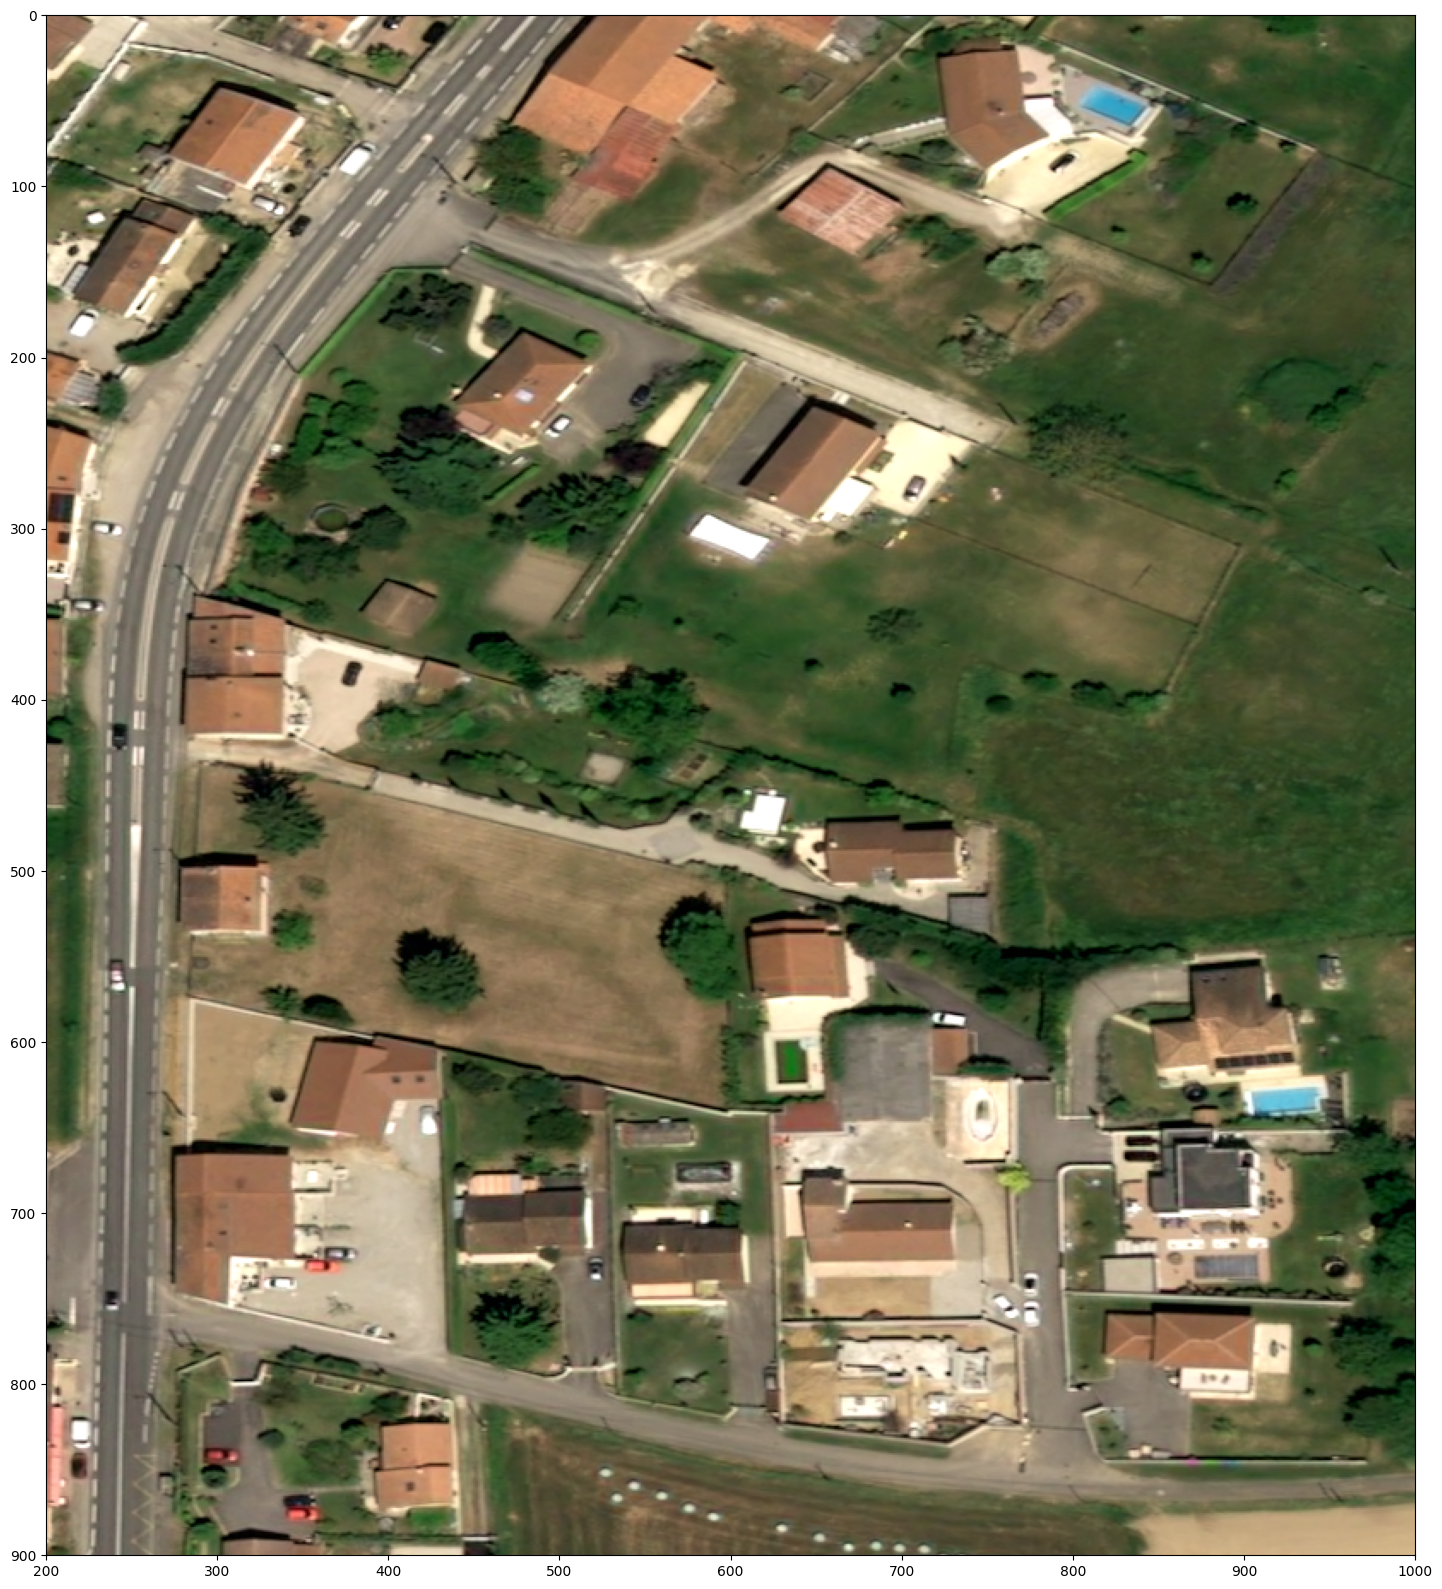

In [20]:
plt.figure(figsize=(20, 20))
plt.imshow(img0)
plt.xlim(200, 1000)
plt.ylim(900, 0)

(900.0, 0.0)

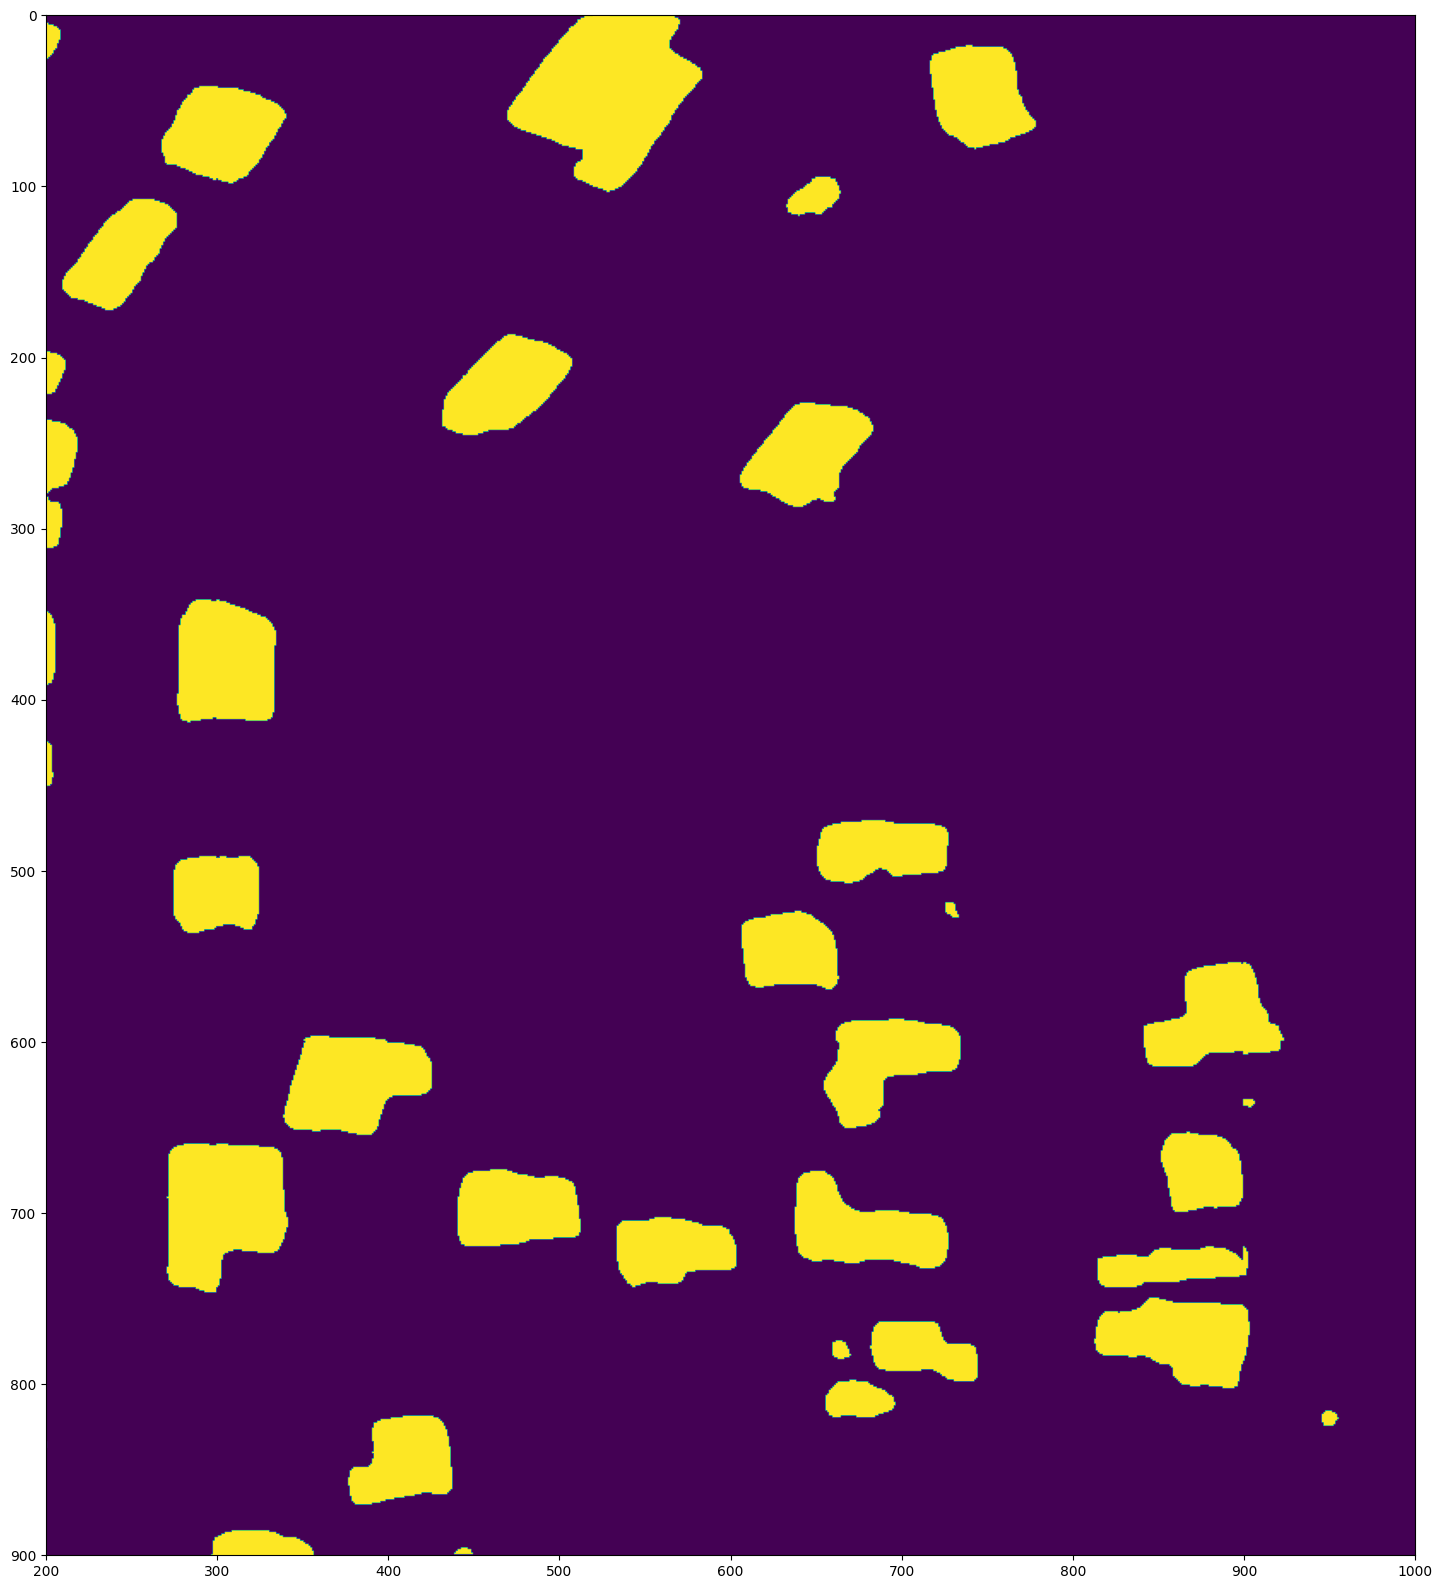

In [23]:
plt.figure(figsize=(20, 20))
plt.imshow(seg1)
plt.xlim(200, 1000)
plt.ylim(900, 0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


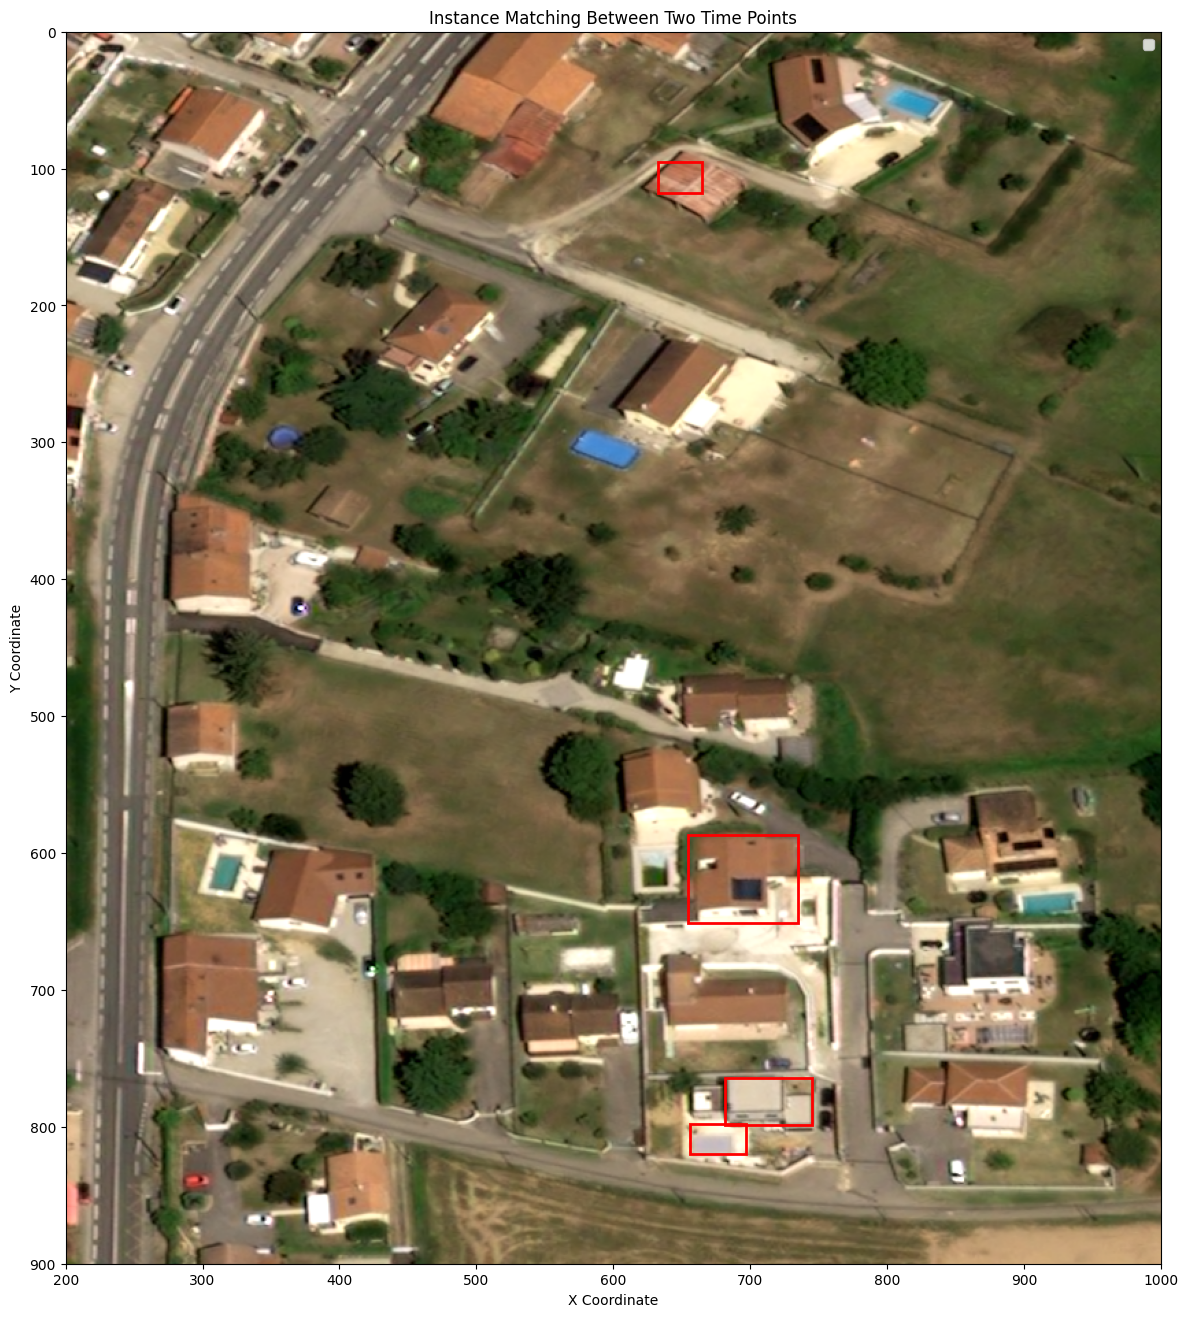

({4, 24, 39, 43, 74, 75, 77, 87}, {4, 74, 75, 77, 87})

In [25]:
# 绘图
fig, ax = plt.subplots(figsize=(16, 16))

ax.imshow(img1)
# 绘制 T1 实例
# for i, inst in enumerate(instances_1):
#     centroid = inst['centroid']
#     bbox = inst['bbox']
#     cy, cx = centroid
#     ax.plot(cx, cy, 'bo')
#     # ax.scatter(*centroid, c='blue', label='T1 Centroid' if inst['label'] == 1 else "")
#     rect = plt.Rectangle((bbox[1], bbox[0]), bbox[3] - bbox[1], bbox[2] - bbox[0],
#                          edgecolor='blue', facecolor='none', linewidth=2, label='T1 Bounding Box' if i == 0 else "")
#     ax.add_patch(rect)

# # 绘制 T2 实例
# for i, inst in enumerate(instances_2):
#     centroid = inst['centroid']
#     bbox = inst['bbox']
#     cy, cx = centroid
#     ax.plot(cx, cy, 'go')
#     # ax.scatter(*centroid, c='green', label='T2 Centroid' if inst['label'] == 1 else "")
#     rect = plt.Rectangle((bbox[1], bbox[0]), bbox[3] - bbox[1], bbox[2] - bbox[0],
#                          edgecolor='green', facecolor='none', linewidth=2, label='T2 Bounding Box' if i == 0 else "")
#     ax.add_patch(rect)

# 绘制匹配线
# for pair in matched_pairs:
#     centroid_t1 = pair[0]['centroid']
#     centroid_t2 = pair[1]['centroid']
#     ax.plot([centroid_t1[1], centroid_t2[1]], [centroid_t1[0], centroid_t2[0]], 'w', linewidth=1, label='Matching Line' if pair == matched_pairs[0] else "")

# for pair in nearest_pairs1:
#     centroid_t1 = pair[0]['centroid']
#     centroid_t2 = pair[1]['centroid']
#     ax.plot([centroid_t1[1], centroid_t2[1]], [centroid_t1[0], centroid_t2[0]], 'gray', linewidth=1, label='nearest Line' if pair == nearest_pairs1[0] else "")

# for pair in nearest_pairs2:
#     centroid_t1 = pair[0]['centroid']
#     centroid_t2 = pair[1]['centroid']
#     ax.plot([centroid_t1[1], centroid_t2[1]], [centroid_t1[0], centroid_t2[0]], 'gray', linewidth=1, label='nearest Line' if pair == nearest_pairs2[0] and nearest_pairs1==[] else "")

for label in change_in_2:
    bbox = instances_2[label]['bbox']
    rect = plt.Rectangle((bbox[1], bbox[0]), bbox[3] - bbox[1], bbox[2] - bbox[0],
                         edgecolor='red', facecolor='none', linewidth=2)
    ax.add_patch(rect)

ax.legend()
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_title('Instance Matching Between Two Time Points')
ax.set_xlim(200, 1000)
ax.set_ylim(900, 0)
# ax.set_xlim(2500, 3200)
# ax.set_ylim(1800, 900)
plt.show()
change_in_2, not_matched_2

In [15]:
'''
投影问题有时很严重，不知是否需要解决


灰色远距离需要规避 : check
'''

'\n投影问题有时很严重，不知是否需要解决\n\n\n灰色远距离需要规避 : check\n'